Scatter plot fairness vs accuracy

In [1]:
import gc
import os
import warnings
from os import path
import pickle
from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
sample_size = 56
plots_dir = os.path.join('out', 'plots', f'n{sample_size}', 'scatter')
calculations_dir = os.path.join('out', 'calculations', f'n{sample_size}')
timer_dir = path.join('out', 'time')

os.makedirs(plots_dir, exist_ok=True)
os.makedirs(calculations_dir, exist_ok=True)
os.makedirs(timer_dir, exist_ok=True)

metrics = {
    'acc_equality_diff.bin': 'Accuracy equality',
    'equal_opp_diff.bin': 'Equal opportunity',
    'pred_equality_diff.bin': 'Predictive equality',
    'stat_parity.bin': 'Statistical parity',
    'neg_pred_parity_diff.bin': 'Negative predictive parity',
    'pos_pred_parity_diff.bin': 'Positive predictive parity',
}

plt.style.use('default')

# adjust font size on plots
SMALL_SIZE = MEDIUM_SIZE = 14
BIGGER_SIZE = 15

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

class Timer:
    def __init__(self):
        self.records = list()
        self.current = None
        self.start_t = None
        self.last_t = None

    def start(self):
        if self.current:
            self.records.append(self.current)
        self.current = dict()
        self.start_t = perf_counter()
        self.last_t = perf_counter()

        return self

    def checkpoint(self, label: str, from_start=False):
        assert self.last_t is not None, "Start the timer first!"

        t = perf_counter()
        if from_start:
            self.current[label] = t - self.start_t
        else:
            self.current[label] = t - self.last_t
        self.last_t = t

        return self.current[label]

    def reset(self):
        if self.current:
            self.records.append(self.current)
        self.current = None
        self.start_t = None
        self.last_t = None

    def print(self):
        for rec in self.records:
            for k, v in rec.items():
                print(f'{k}:\t {v}')
            print('\n')

    def to_file(self, fn='scatter.csv'):
        with open(path.join(timer_dir, fn), 'a') as f:
            for rec in self.records:
                for k, v in rec.items():
                    f.write(f'{k}, {v}\n')
                f.write('\n')
            f.write('\n\n')

In [3]:
def get_accuracy():
    data_cols = [
        'i_tp',     # minority true positive
        'i_fp',     # minority false positive
        'i_tn',     # minority true negative
        'i_fn',     # minority false negative
        'j_tp',     # majority true positive
        'j_fp',     # majority false positive
        'j_tn',     # majority true negative
        'j_fn',     # majority false negative
    ]
    sample_size = 56
    dataset_path = path.join('out', f'Set(08,{sample_size}).bin')
    with open(dataset_path, "rb") as f:
        df = pd.DataFrame(pickle.load(f), columns=data_cols)
    
    # with open(path.join(calculations_dir, "accuracy.bin"), "wb+") as f:
    #     # (TP + TN) / sum(row)
    acc = (df['i_tp'] + df['i_tn'] + df['j_tp'] + df['j_tn']) / sample_size
    
    del df
    return acc

In [4]:
# # uncomment if accuracy is not calculated yet

# with open(path.join(calculations_dir, "accuracy.bin"), "wb+") as f:
#     get_accuracy().to_numpy().tofile(f)

In [5]:
# def scatter_v1(accuracy, metric_file, metric_name):
#     # for all combinations, take the fairness metric value and accuracy and plot the points with their coordinates
# 
#     with open(path.join(calculations_dir, metric_file), 'rb') as f:
#         fairness = pd.DataFrame(np.fromfile(f).astype(np.float16),
#                          columns=['fairness'])
# 
#     fig, ax = plt.subplots(figsize=(9, 8))
# 
#     ax.scatter(
#         accuracy,
#         fairness,
#         s=1,
#         alpha=.02
#     )
#     ax.set_xlabel('Accuracy')
#     ax.set_ylabel(metric_name)
#     
#     plt.tight_layout()
#     fig.savefig(path.join(plots_dir, f'acc_vs_{metric_name}.png'), dpi=300)
#     plt.close(fig)
#     
#     del fairness

In [6]:
def save_counts(accuracy, metric_file, metric_name):
    with open(path.join(calculations_dir, metric_file), 'rb') as f:
        df = pd.concat([
            accuracy,
            pd.DataFrame(np.fromfile(f).astype(np.float16), columns=[metric_name])
        ], axis=1)
    
    df = df.groupby(['accuracy', metric_name]).size().reset_index(name='count')
    
    fn = path.join(calculations_dir, f'counts_acc_vs_{metric_file.replace(".bin", ".csv")}')
    with open(fn, 'w+') as f:
        df.to_csv(f, index=False)
    print(fn)
    del df

In [7]:
# scatter with point size

def scatter_v2(metric_file, metric_name):
    with open(path.join(calculations_dir, f'counts_acc_vs_{metric_file.replace(".bin", ".csv")}'), 'r') as f:
        df = pd.read_csv(f)
    
    # print(df.head())
    
    # v2.1
    fig, ax = plt.subplots(figsize=(9, 8))
    ax.scatter(
        df['accuracy'],
        df[metric_name],
        # s=df['count'] / 10**3,
        s=np.log2(df['count']),
        alpha=.1,
        lw=0,
        plotnonfinite=True
    )
    ax.set_xlabel('Accuracy')
    ax.set_ylabel(metric_name)
    ax.set_title('v1')
    plt.tight_layout()
    fig.savefig(path.join(plots_dir, f'v2_1_acc_vs_{metric_name}.png'), dpi=300)
    plt.close(fig)
    
    # v2.2
    fig, ax = plt.subplots(figsize=(9, 8))
    ax.scatter(
        df['accuracy'],
        df[metric_name],
        # s=np.log2(df['count']),
        s=np.log2(df['count'] / 10),
        alpha=.1,
        lw=0,
    )
    ax.set_xlabel('Accuracy')
    ax.set_ylabel(metric_name)
    ax.set_title('v2')
    plt.tight_layout()
    fig.savefig(path.join(plots_dir, f'v2_2_acc_vs_{metric_name}.png'), dpi=300)
    plt.close(fig)

    # v2.3
    fig, ax = plt.subplots(figsize=(9, 8))
    ax.scatter(
        df['accuracy'],
        df[metric_name],
        s=np.log10(df['count']),
        alpha=.1,
        lw=0,
    )
    ax.set_xlabel('Accuracy')
    ax.set_ylabel(metric_name)
    ax.set_title('v3')
    plt.tight_layout()
    fig.savefig(path.join(plots_dir, f'v2_3_acc_vs_{metric_name}.png'), dpi=300)
    plt.close(fig)

In [8]:
def scatter_v3(metric_file, metric_name):
    with open(path.join(calculations_dir, f'counts_acc_vs_{metric_file.replace(".bin", ".csv")}'), 'r') as f:
        df = pd.read_csv(f)
    
    # use seaborn to plot the scatter with jitter
    
    fig, ax = plt.subplots(figsize=(9, 8))
    sns.scatterplot(
        data=df,
        x='accuracy',
        y=metric_name,
        size='count',
        sizes=(1, 100),
        alpha=.1,
        ax=ax
    )
    ax.set_xlabel('Accuracy')
    ax.set_ylabel(metric_name)
    plt.tight_layout()
    fig.savefig(path.join(plots_dir, f'v3_acc_vs_{metric_name}.png'), dpi=300)

In [27]:
def heatmap_v1(metric_file, metric_name):
    with open(os.path.join(calculations_dir,
                        f'counts_acc_vs_{metric_file.replace(".bin", ".csv")}'),
              'r') as f:
        df = pd.read_csv(f)
    dfp = df.pivot(index='accuracy', columns=metric_name, values='count')
    
    fig, ax = plt.subplots(figsize=(9, 8))
    sns.heatmap(
        dfp,
        annot=False,
        cbar_kws={'label': 'Count'},
        # alpha=.1,
        ax=ax
    )
    ax.invert_yaxis()
    ax.set_xlabel('Accuracy')
    ax.set_ylabel(metric_name)
    
    ax.set_title(f'{metric_name} vs Accuracy')
    xt = [ax.get_xticklabels()[0]] + ["" for _ in range(len(ax.get_xticklabels()) - 2)] + [ax.get_xticklabels()[-1]]
    yt = [ax.get_yticklabels()[0]] + ["" for _ in range(len(ax.get_yticklabels()) - 2)] + [ax.get_yticklabels()[-1]]
    ax.set_xticklabels(xt, rotation=30)
    ax.set_yticklabels(yt, rotation=30)
    
    plt.tight_layout()
    fig.savefig(os.path.join(plots_dir, f'hm_v1_acc_vs_{metric_name}.png'), dpi=300)

In [28]:
# # just read the metric values from files
# with open(path.join(calculations_dir, 'accuracy.bin'), 'rb') as f:
#     acc = pd.DataFrame(np.fromfile(f).astype(np.float32), columns=['accuracy'])

Accuracy equality
Equal opportunity
Predictive equality
Statistical parity
Negative predictive parity
Positive predictive parity


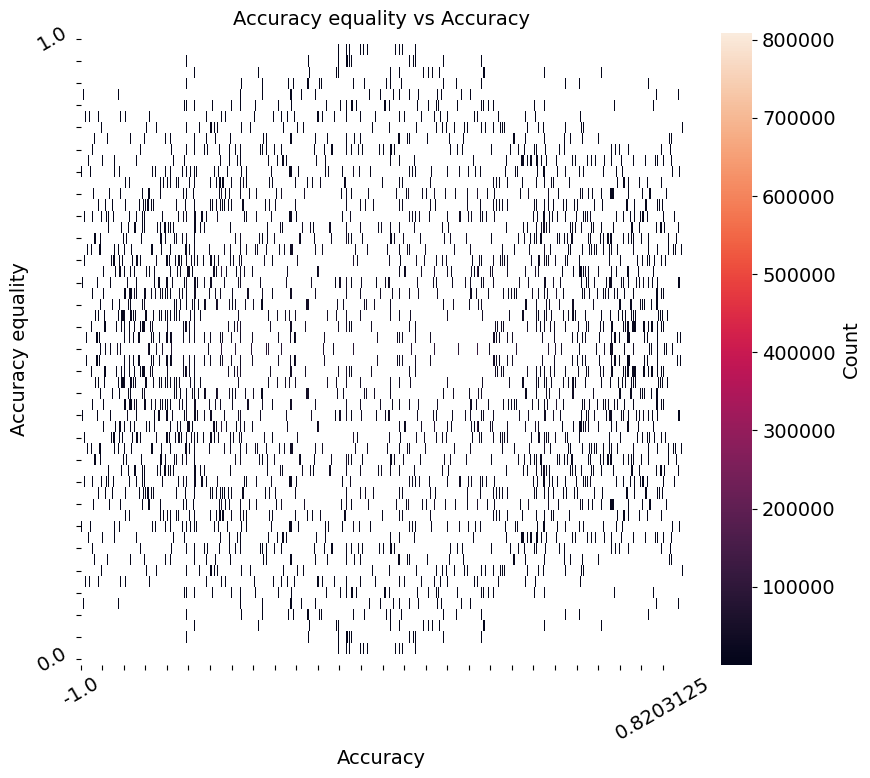

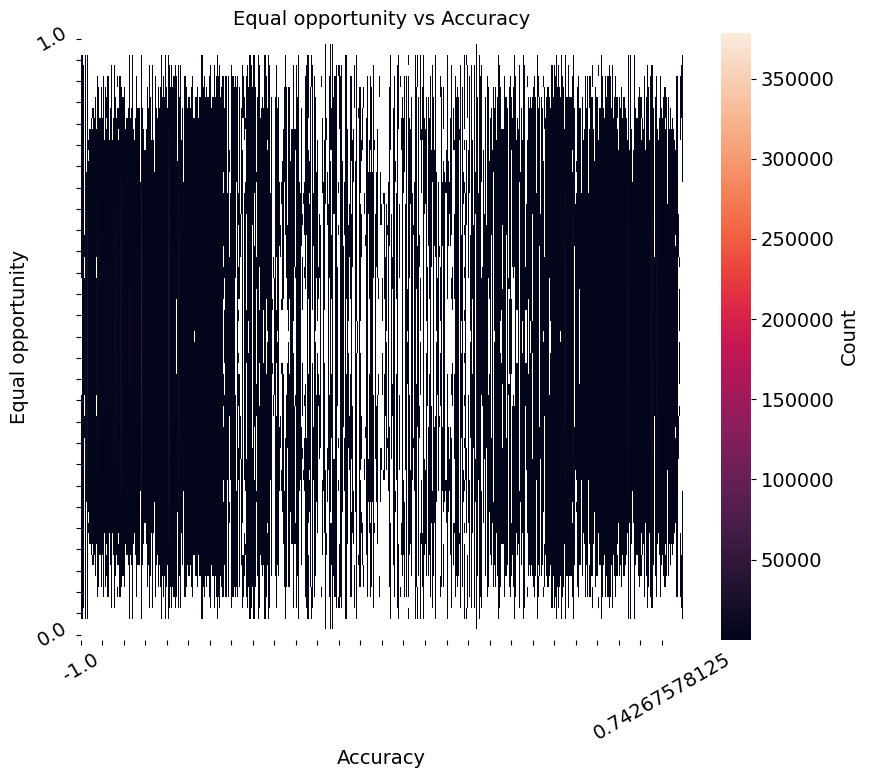

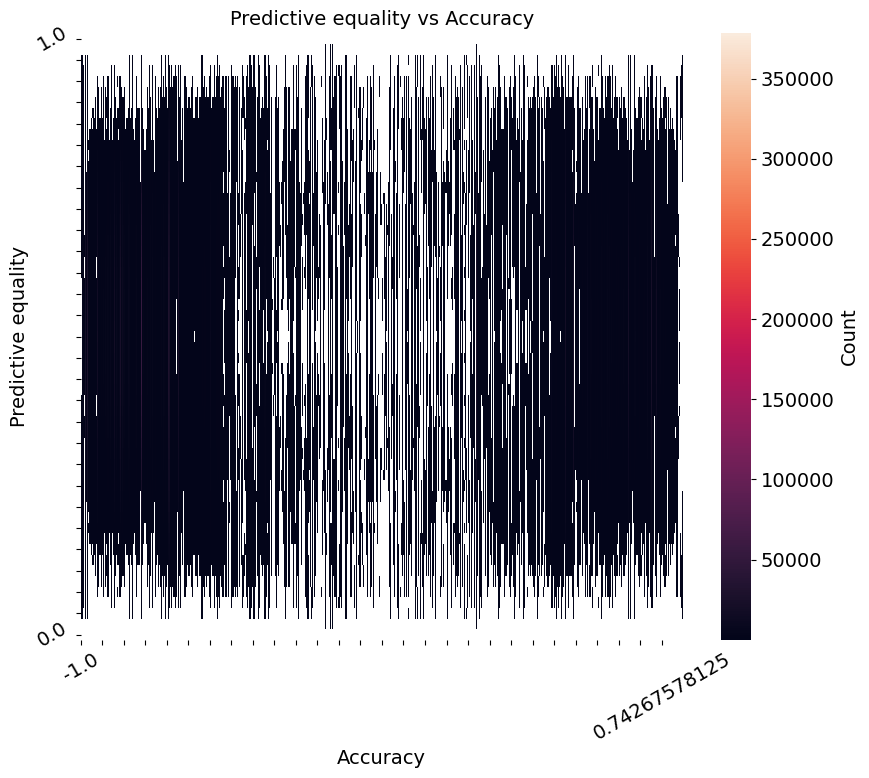

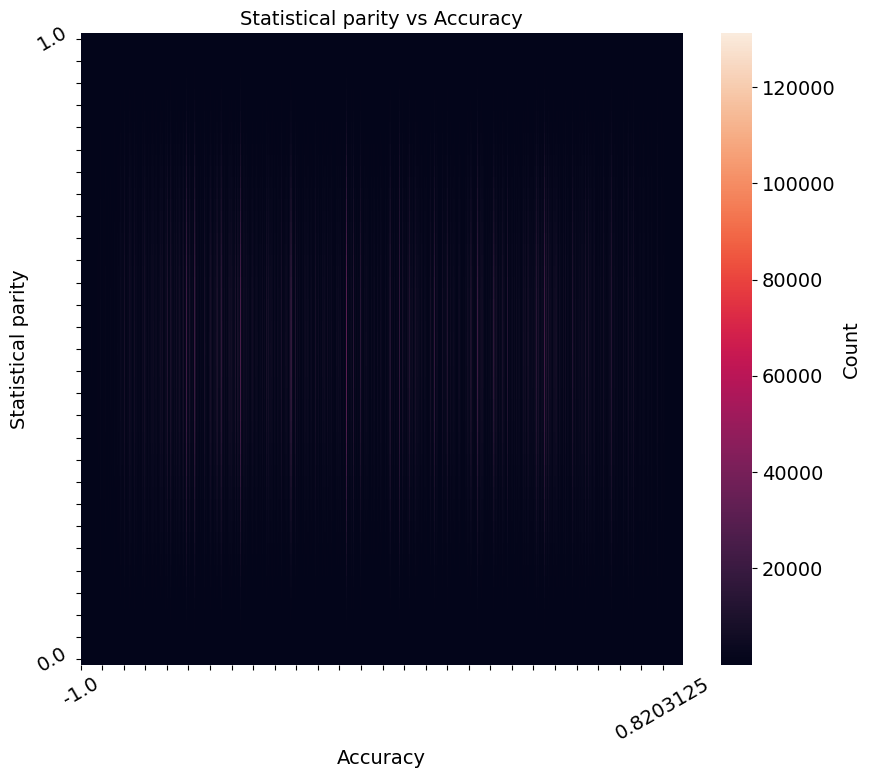

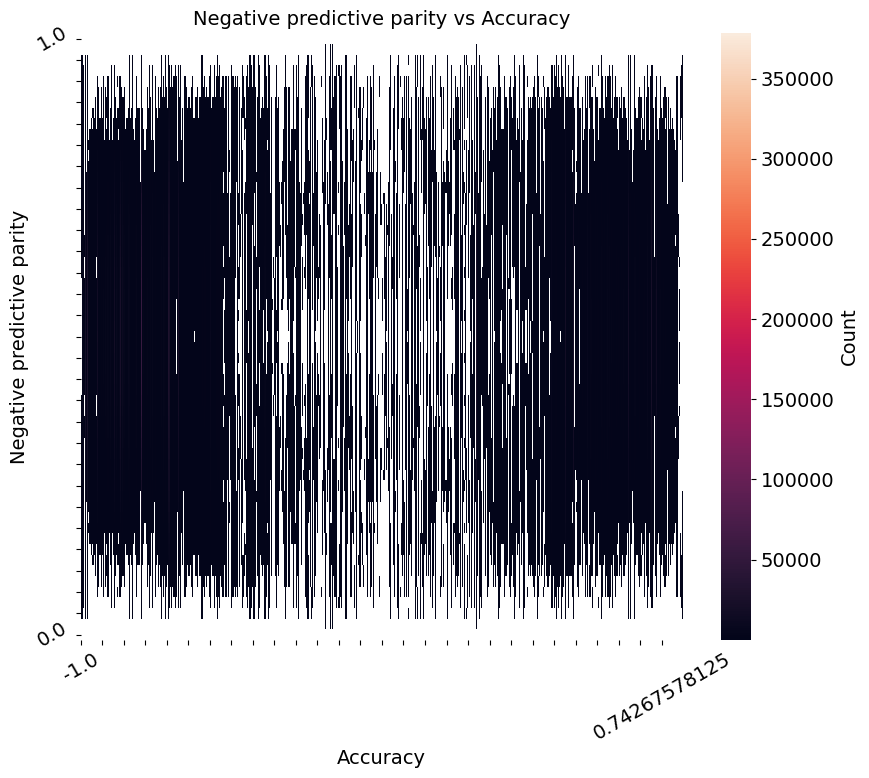

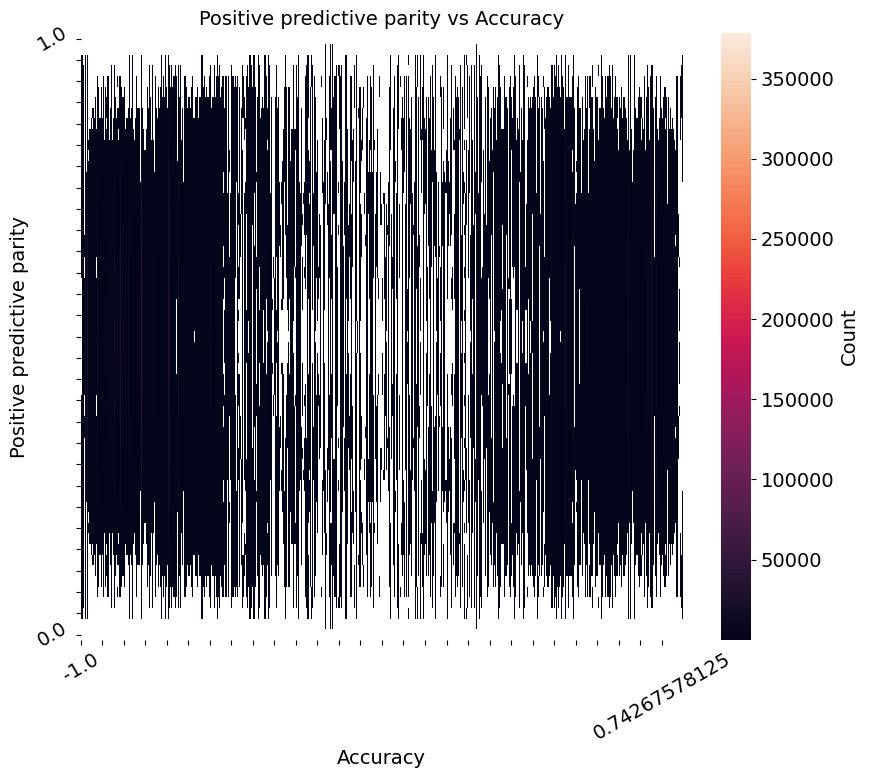

In [29]:
scatter = heatmap_v1

for mf, mn in [
    ('acc_equality_diff.bin', 'Accuracy equality'),
    ('equal_opp_diff.bin', 'Equal opportunity'),
    ('pred_equality_diff.bin', 'Predictive equality'),
    ('stat_parity.bin', 'Statistical parity'),
    ('neg_pred_parity_diff.bin', 'Negative predictive parity'),
    ('pos_pred_parity_diff.bin', 'Positive predictive parity'),
]:
    print(mn)
    # save_counts(acc, mf, mn)
    scatter(mf, mn)
    gc.collect()